In [271]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
import torch
import torch.nn as nn

In [272]:
file_path = '/kaggle/input/burgers-solution-1000-v0-01/burger_solution_1000_0.01_upwind_scheme.npy' # change it accordingly

In [273]:
with open(file_path, 'rb') as f:
    usol =  np.load(f)

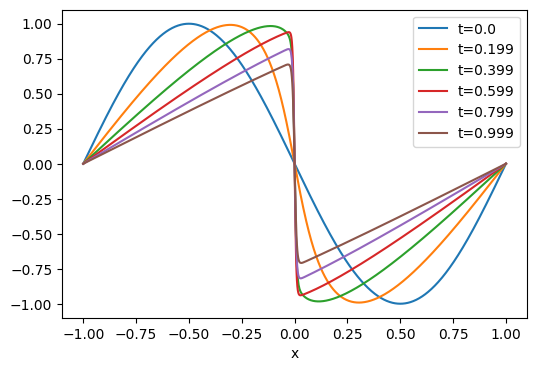

In [274]:
# Visualize some of the data, for some values of t
fig, ax = plt.subplots(1,figsize=(6,4))
for j in [0,199,399,599,799,999]:
    ax.plot(np.linspace(-1, 1, 1000), usol[j,:], label=f't={j/usol.shape[0]}')
ax.set_xlabel('x')
ax.legend()
fig.show()

# the first dimension is t (usol[t,:] is all x at time t)
# second dimension is x 

In [275]:
class ScalingLayer(nn.Module):
    def __init__(self, scale_init_value=1, bias_init_value=0):
        super().__init__()
        self.scale = nn.Parameter(torch.FloatTensor([scale_init_value]))
        self.bias = nn.Parameter(torch.FloatTensor([bias_init_value]))

    def forward(self, input):
        return input * self.scale + self.bias
    
    
class U(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            print(x)
            x = layer(x)
            print(x)
        return x
    
class F(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [276]:
u = U(2,1, [20]*8)

### Get Collocation points

In [277]:
def generate_latin_hyper_c_sampling(Nd=10000):
    sampler = qmc.LatinHypercube(d=2)
    sample_pos = sampler.random(n=Nd//2)
    sample_neg = sampler.random(n=Nd//2)
    sample_neg[:,1] = -sample_neg[:,1]

    return np.vstack([sample_pos, sample_neg])

In [278]:
collocation_p = generate_latin_hyper_c_sampling(10**4)

In [279]:
# first column is in range [0,1] (represents t)
assert collocation_p[:,0].min() > 0
assert collocation_p[:,0].max() < 1

# second column is in range [-1,1] (represents x)
assert collocation_p[:,1].min() > -1
assert collocation_p[:,1].max() < 1

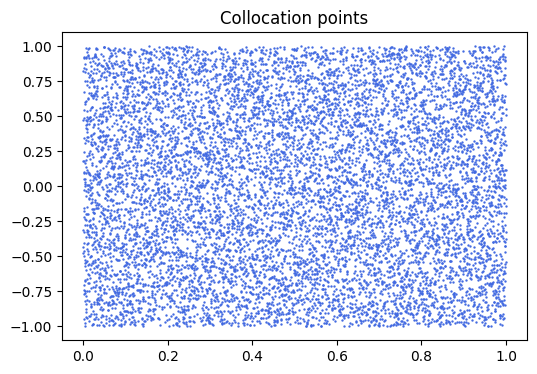

In [280]:
fig, ax = plt.subplots(1,figsize=(6,4))
ax.scatter(collocation_p[:,0], collocation_p[:,1], s=0.5, color='royalblue')
ax.set_title('Collocation points')
fig.show()

### Get training data

In [281]:
def get_train_data(n, t, usol):
    t_index = int(t*usol.shape[1])
    
    x_indices = np.arange(0, usol.shape[1], usol.shape[1]//n)
    u_vals = usol[t_index, x_indices]
    u_vals = u_vals.reshape(-1,1)
    
    x_vals = ((x_indices * (2/1000)) -1)
    x_vals = x_vals.reshape(-1,1)
    t_vals = np.array([t]*x_vals.shape[0])
    t_vals = t_vals.reshape(-1,1)
    
    # INPUT: [[0,x1],[0,x2], [0,x3]...[0,x_n]], TARGET = u_vals
    
    return np.concatenate([t_vals, x_vals], axis=1), u_vals

In [282]:
train_data_t05, target_t05 = get_train_data(100, 0.5, usol)
train_data_t0, target_t0 = get_train_data(100, 0, usol)

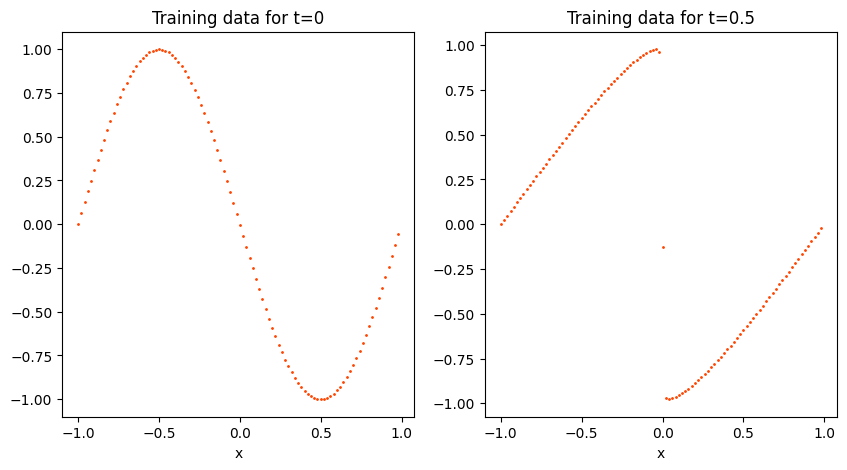

In [283]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(train_data_t0[:,1], target_t0[:,0], s=1, color='orangered')
ax[0].set_title('Training data for t=0')
ax[0].set_xlabel('x')
ax[1].scatter(train_data_t05[:,1], target_t05[:,0], s=1, color='orangered')
ax[1].set_title('Training data for t=0.5')
ax[1].set_xlabel('x')
fig.show()

### Training

In [284]:
# TODO